In [1]:
import hdbscan
import pandas as pd
import numpy as np
%matplotlib ipympl
import matplotlib.pyplot as plt
from sklearn import manifold
from ipywidgets import interact, Output
from IPython.display import clear_output

import sys
sys.path.append('..')
from src.band_plotters import DATA_DIRECTORY
from src.cluster_plotters import plot_cluster_ellipses, plot_groups

In [2]:
FINGERPRINT_NAME = "all_k_branches_histogram_-8_to_8"
FINGERPRINT_LENGTH = 60
PERPLEXITY = 30
FLAT_ONLY = True
BORING_COLUMNS = ["segments", "flat_segments", "flatness_score", "binary_flatness", "horz_flat_seg", "exfoliation_eg", "band_gap", "A", "B", "C", "D", "E", "F"]
INPUT_NAME = f"{FINGERPRINT_NAME}_perplexity_{PERPLEXITY}_length_{FINGERPRINT_LENGTH}.csv"

## Load Data

In [3]:
df = pd.read_csv(f"../fingerprints/{INPUT_NAME}", index_col="ID")
if FLAT_ONLY:
    df = df[df.horz_flat_seg>0]
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,52,53,54,55,56,57,58,59,fx,fy
ID,,,,,,,,,,,,,,,,,,,,,
2dm-3,TlS,AB,2,4,4,0.84646,bottom-up,1,3,0.095794,...,55.0,39.0,24.0,60.0,77.0,87.0,144.0,169.0,56.956955,-30.273296
2dm-21,TaI3,AB3,162,3,3,0.88201,bottom-up,1,1,0.097255,...,40.0,55.0,37.0,66.0,84.0,91.0,103.0,28.0,-70.431740,68.783394
2dm-22,Li2O,AB2,164,3,3,0.96678,bottom-up,1,4,0.037593,...,11.0,19.0,33.0,39.0,35.0,54.0,47.0,48.0,-114.084400,-27.390778
2dm-25,VBr4,AB4,123,3,3,0.97834,bottom-up,1,2,0.140290,...,13.0,9.0,0.0,0.0,7.0,37.0,51.0,50.0,-79.971310,30.631958
2dm-29,SBr,AB,2,4,4,0.82037,bottom-up,1,3,0.067035,...,52.0,0.0,68.0,16.0,29.0,13.0,0.0,134.0,58.959020,-67.769530


## Cluster

In [4]:
fingerprint_cols = [str(i) for i in range(FINGERPRINT_LENGTH)]
BORING_COLUMNS += fingerprint_cols

In [5]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=4, min_samples=4, p=0.2)
clusterer.fit(df[fingerprint_cols])

df["labels"] = clusterer.labels_

interactive(children=(IntSlider(value=13, description='label', max=27, min=-1), Output()), _dom_classes=('widg…

<function __main__.view_cluster(label)>

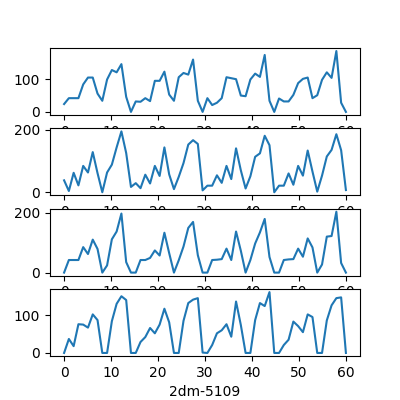

In [6]:
def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(100))

    num_plots = len(df[df.labels==label])

    fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols])
        ax[i].set_xlabel(index)
    
    
interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))

## Rerun TSNE (ONLY IF ON FLAT SUBSET)

In [8]:
if FLAT_ONLY:
    tsne = manifold.TSNE(n_components=2, early_exaggeration=12.0, init="pca",learning_rate=100, random_state=0, perplexity=PERPLEXITY ,n_iter=10000, verbose=2)
    fingerprint_2d = tsne.fit_transform(df[fingerprint_cols])
    df.fx, df.fy = fingerprint_2d[:, 0], fingerprint_2d[:, 1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2005 samples in 0.002s...
[t-SNE] Computed neighbors for 2005 samples in 0.306s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2005
[t-SNE] Computed conditional probabilities for sample 2000 / 2005
[t-SNE] Computed conditional probabilities for sample 2005 / 2005
[t-SNE] Mean sigma: 136.899946
[t-SNE] Computed conditional probabilities in 0.115s
[t-SNE] Iteration 50: error = 73.2548676, gradient norm = 0.0116185 (50 iterations in 0.506s)
[t-SNE] Iteration 100: error = 72.5006866, gradient norm = 0.0001288 (50 iterations in 0.404s)
[t-SNE] Iteration 150: error = 72.4938965, gradient norm = 0.0001011 (50 iterations in 0.411s)
[t-SNE] Iteration 200: error = 72.4955139, gradient norm = 0.0001418 (50 iterations in 0.385s)
[t-SNE] Iteration 250: error = 72.4962463, gradient norm = 0.0001900 (50 iterations in 0.465s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.496246
[t-SNE] Iteration 300: er

## Plots

Output()

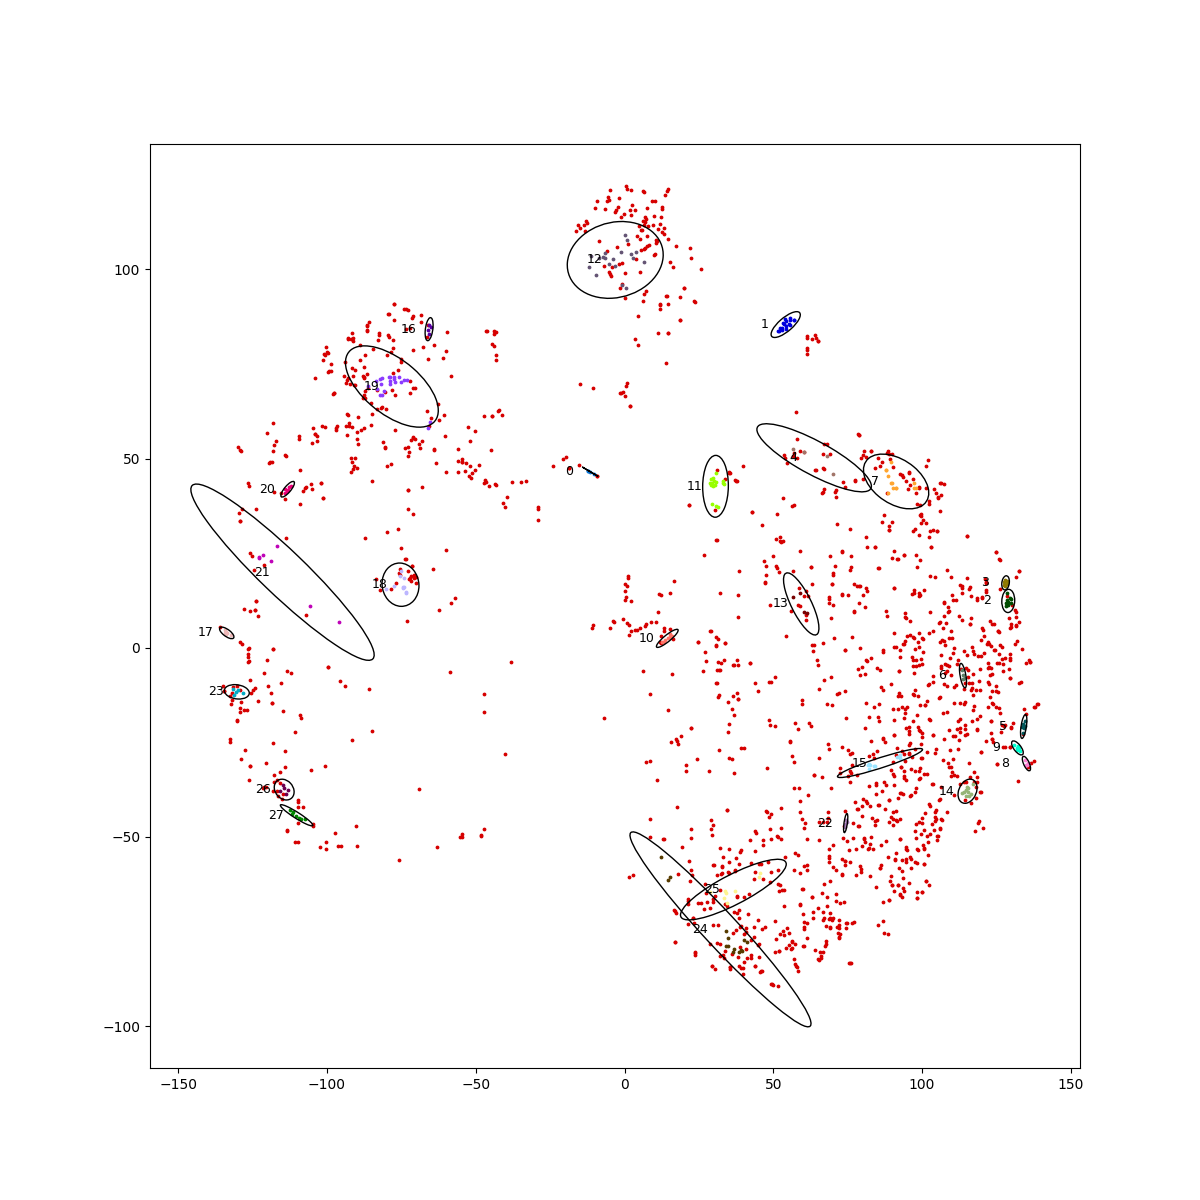

In [7]:
out = Output()

@out.capture()
def onclick(event):
    clear_output()
    closest = np.sqrt((event.xdata-df.fx)**2 + (event.ydata-df.fy)**2).idxmin()
    label = df.labels.loc[closest]
    print(f"Clicked on material {closest} in cluster {label}")
    display(df[df.labels == label].drop(BORING_COLUMNS, axis=1))
display(out)

fig, ax = plt.subplots(figsize=(12, 12))
ax = plot_groups(df,"labels", ax=ax)
ax = plot_cluster_ellipses(df, ax=ax, color="black")
# ax.legend()

fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()